# Industrial-scale penicillin production analysis

## 1. Import necessary packages

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import display

import piecewise_regression

## 2. Import data sets and investigate data structure

In [2]:
# Load the time series process data
variable_data = pd.read_csv('100_Batches_IndPenSim_V3_variable_data.csv') 
# Load the penicillin yield statistics data
data_summary = pd.read_csv('Mendeley_data/100_Batches_IndPenSim_Statistics.csv')

In [3]:
# Set display option to show all columns
pd.set_option('display.max_columns', None)

In [4]:
data_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Batch ref                              100 non-null    int64  
 1   Penicllin_harvested_during_batch(kg)   100 non-null    float64
 2   Penicllin_harvested_end_of_batch (kg)  100 non-null    float64
 3   Penicllin_yield_total (kg)             100 non-null    float64
 4   Fault ref(0-NoFault 1-Fault)           100 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 4.0 KB


In [5]:
data_summary

,Batch ref,Penicllin_harvested_during_batch(kg),Penicllin_harvested_end_of_batch (kg),Penicllin_yield_total (kg),Fault ref(0-NoFault 1-Fault)
0,1,1066400.0,1720000.0,2786400.0,0
1,2,985910.0,1340100.0,2326000.0,0
2,3,1416100.0,1259200.0,2675300.0,0
3,4,815700.0,1071000.0,1886700.0,0
4,5,1128500.0,2434400.0,3562900.0,0
...,...,...,...,...,...
95,96,1141500.0,2453400.0,3595000.0,1
96,97,1439400.0,2454900.0,3894300.0,1
97,98,799760.0,930830.0,1730600.0,1
98,99,388650.0,502180.0,890830.0,1


In [6]:
variable_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113935 entries, 0 to 113934
Data columns (total 39 columns):
 #   Column                                                              Non-Null Count   Dtype  
---  ------                                                              --------------   -----  
 0   Time (h)                                                            113935 non-null  float64
 1   Aeration rate(Fg:L/h)                                               113935 non-null  float64
 2   Agitator RPM(RPM:RPM)                                               113935 non-null  float64
 3   Sugar feed rate(Fs:L/h)                                             113935 non-null  float64
 4   Acid flow rate(Fa:L/h)                                              113935 non-null  float64
 5   Base flow rate(Fb:L/h)                                              113935 non-null  float64
 6   Heating/cooling water flow rate(Fc:L/h)                             113935 non-null  float64
 7   He

## 3. Analyze the original data set

In [7]:
# Handling missing values

# 5 off-line measurement variables contain missing values due to their measurement frequency:
# 1. PAA concentration offline(PAA_offline:PAA (g L^{-1}))
# 2. NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))
# 3. Offline Penicillin concentration(P_offline:P(g L^{-1}))
# 4. Offline Biomass concentratio(X_offline:X(g L^{-1}))
# 5. Viscosity(Viscosity_offline:centPoise)

# These measurements include a pre-defined delay (4 time steps) as noted in the reference paper.

In [8]:
# Create a new column to indicate the batch length
# A value of 1 means fixed length (230 hours), and 0 means variable length
time_group = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Time (h)'].max()
fixed_batch = time_group[time_group == 230].index

# Create a new column with default value 0
variable_data['0 - Variable 1 - Fixed(Batch_length:Batch length)'] = 0

# Set the value to 1 for batches with max time = 230 hours (fixed length)
for batch in fixed_batch:
    variable_data.loc[variable_data['Batch reference(Batch_ref:Batch ref)'] == batch, '0 - Variable 1 - Fixed(Batch_length:Batch length)'] = 1

In [9]:
variable_data

,Time (h),Aeration rate(Fg:L/h),Agitator RPM(RPM:RPM),Sugar feed rate(Fs:L/h),Acid flow rate(Fa:L/h),Base flow rate(Fb:L/h),Heating/cooling water flow rate(Fc:L/h),Heating water flow rate(Fh:L/h),Water for injection/dilution(Fw:L/h),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Penicillin concentration(P:g/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),pH(pH:pH),Temperature(T:K),Generated heat(Q:kJ),carbon dioxide percent in off-gas(CO2outgas:%),PAA flow(Fpaa:PAA flow (L/h)),PAA concentration offline(PAA_offline:PAA (g L^{-1})),Oil flow(Foil:L/hr),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Oxygen Uptake Rate(OUR:(g min^{-1})),Oxygen in percent in off-gas(O2:O2 (%)),Offline Penicillin concentration(P_offline:P(g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Carbon evolution rate(CER:g/h),Ammonia shots(NH3_shots:kgs),Viscosity(Viscosity_offline:centPoise),Fault reference(Fault_ref:Fault ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),1- No Raman spec,1-Raman spec recorded,Batch reference(Batch_ref:Batch ref),2-PAT control(PAT_ref:PAT ref),Batch ID,Fault flag,0 - Variable 1 - Fixed(Batch_length:Batch length)
0,0.2,30.0,100.0,8.0,0.0000,30.1180,9.8335,0.00010,0.0,0.6,0.0,0.95749,14.711,1.017800e-25,58479.0,62574.0,6.4472,298.22,0.000001,0.089514,5.0,NaN,22.0,NaN,0.480510,0.19595,NaN,NaN,0.034045,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
1,0.4,30.0,100.0,8.0,0.0000,51.2210,18.1550,0.00010,0.0,0.6,0.0,1.00460,14.699,1.000000e-03,58487.0,62585.0,6.4932,298.17,0.000001,0.101760,5.0,NaN,22.0,NaN,0.058147,0.20390,NaN,NaN,0.038702,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
2,0.6,30.0,100.0,8.0,0.0000,54.3020,9.5982,0.00010,0.0,0.6,0.0,1.04980,14.686,9.993400e-04,58495.0,62598.0,6.5425,298.14,0.000001,0.105800,5.0,NaN,22.0,NaN,-0.041505,0.20575,NaN,NaN,0.040240,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
3,0.8,30.0,100.0,8.0,0.0000,37.8160,4.3395,0.00010,0.0,0.6,0.0,1.09420,14.661,9.987400e-04,58499.0,62607.0,6.5753,298.11,0.000001,0.108190,5.0,NaN,22.0,NaN,-0.056737,0.20602,NaN,NaN,0.041149,0.0,NaN,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
4,1.0,30.0,100.0,8.0,0.5181,18.9080,1.1045,0.00010,0.0,0.6,0.0,1.13700,14.633,9.982100e-04,58501.0,62613.0,6.5825,298.09,0.000001,0.110300,5.0,1488.0,22.0,1667.8,-0.049975,0.20589,1.017800e-25,0.52808,0.041951,0.0,4.083,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,229.2,65.0,100.0,80.0,0.0000,12.9000,33.5860,5.93590,250.0,0.9,0.0,72.70800,13.385,5.656700e+00,74071.0,84211.0,6.5085,297.89,215.090000,1.204400,4.0,NaN,23.0,NaN,0.323420,0.19996,NaN,NaN,0.995500,0.0,NaN,0.0,0.0,1.0,100.0,100.0,1.0,43854.0,44034.0,1
113931,229.4,65.0,100.0,80.0,0.0000,10.0470,10.0760,98.83400,250.0,0.9,0.0,72.77400,13.388,5.649000e+00,74133.0,84281.0,6.5080,298.07,278.390000,1.204100,4.0,NaN,23.0,NaN,0.316620,0.20002,NaN,NaN,0.995220,0.0,NaN,0.0,0.0,1.0,100.0,100.0,1.0,44814.0,44659.0,1
113932,229.6,65.0,100.0,80.0,0.0000,7.3609,69.3450,9.88340,250.0,0.9,0.0,72.84200,13.390,5.641400e+00,74194.0,84350.0,6.5040,297.98,246.050000,1.203800,4.0,NaN,23.0,NaN,0.311680,0.20006,NaN,NaN,0.994940,0.0,NaN,0.0,0.0,1.0,100.0,100.0,1.0,44273.0,43952.0,1
113933,229.8,65.0,100.0,80.0,0.0000,6.2794,38.6100,0.98834,250.0,0.9,0.0,72.91000,13.390,5.633900e+00,74255.0,84420.0,6.4987,297.88,212.630000,1.203400,4.0,NaN,23.0,NaN,0.311780,0.20006,NaN,NaN,0.994660,0.0,NaN,0.0,0.0,1.0,100.0,100.0,1.0,44733.0,45245.0,1


In [10]:
# Check if Agitator RPM is constant (fixed at 100 rpm)
variable_data['Agitator RPM(RPM:RPM)'].unique()

array([100.])

In [11]:
# Check if Ammonia shots are constant (fixed at 0 kg)
variable_data['Ammonia shots(NH3_shots:kgs)'].unique()

array([0.])

In [12]:
# Pre-selection of variables
# Drop:
# - Constant variables (Agitator RPM, Ammonia shots)
# - Reference variables not relevant to our analysis (Fault reference, Raman spec indicators, Batch ID)

variable_data = variable_data.drop(columns=['Agitator RPM(RPM:RPM)','Ammonia shots(NH3_shots:kgs)',
                                            'Fault reference(Fault_ref:Fault ref)','1- No Raman spec',' 1-Raman spec recorded','2-PAT control(PAT_ref:PAT ref)',
                                            'Batch ID','Fault flag'])

In [13]:
# Correct the oxygen uptake rate column name to reflect actual units (g/h)
variable_data = variable_data.rename(columns={'Oxygen Uptake Rate(OUR:(g min^{-1}))': 'Oxygen Uptake Rate(OUR:g/h)'})  
# Invert dumped broth flow values to represent removal as positive quantitites
variable_data['Dumped broth flow(Fremoved:L/h)'] = -variable_data['Dumped broth flow(Fremoved:L/h)']

In [14]:
# Calculate cumulative values for variables
# - Manual control
variable_data['Sugar feed (s:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Sugar feed rate(Fs:L/h)'].cumsum()
variable_data['Oil (oil:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Oil flow(Foil:L/hr)'].cumsum()
variable_data['Aeration(g:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Aeration rate(Fg:L/h)'].cumsum()
variable_data['Dumped broth(removed:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Dumped broth flow(Fremoved:L/h)'].cumsum()
variable_data['Water (w:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Water for injection/dilution(Fw:L/h)'].cumsum()
variable_data['PAA (paa: L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['PAA flow(Fpaa:PAA flow (L/h))'].cumsum()
# - Automatic control
variable_data['Acid (a:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Acid flow rate(Fa:L/h)'].cumsum()
variable_data['Base (b:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Base flow rate(Fb:L/h)'].cumsum()
variable_data['Cooling water (c:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Heating/cooling water flow rate(Fc:L/h)'].cumsum()
variable_data['Heating water (h:L)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Heating water flow rate(Fh:L/h)'].cumsum()
# - Online measurements
variable_data['Oxygen Uptake(OU:(g))'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Oxygen Uptake Rate(OUR:g/h)'].cumsum()
variable_data['Carbon evolution(CE:g)'] = variable_data.groupby('Batch reference(Batch_ref:Batch ref)')['Carbon evolution rate(CER:g/h)'].cumsum()

In [15]:
# Reorganize columns into logical groups for better analysis
response_var = ['Penicillin concentration(P:g/L)']
manual_control = ['Sugar feed rate(Fs:L/h)', 'Sugar feed (s:L)',
                  'Oil flow(Foil:L/hr)', 'Oil (oil:L)',
                  'Aeration rate(Fg:L/h)', 'Aeration(g:L)',
                  'Air head pressure(pressure:bar)', 
                  'Dumped broth flow(Fremoved:L/h)', 'Dumped broth(removed:L)',
                  'Water for injection/dilution(Fw:L/h)', 'Water (w:L)',
                  'PAA flow(Fpaa:PAA flow (L/h))', 'PAA (paa: L)']
automatic_control = ['Acid flow rate(Fa:L/h)', 'Acid (a:L)',
                     'Base flow rate(Fb:L/h)', 'Base (b:L)',
                     'Heating/cooling water flow rate(Fc:L/h)', 'Cooling water (c:L)',
                     'Heating water flow rate(Fh:L/h)', 'Heating water (h:L)']
online_measurements = ['Substrate concentration(S:g/L)', 
                       'Dissolved oxygen concentration(DO2:mg/L)', 
                       'Vessel Volume(V:L)', 'Vessel Weight(Wt:Kg)', 
                       'Temperature(T:K)', 'pH(pH:pH)',
                       'carbon dioxide percent in off-gas(CO2outgas:%)', 'Oxygen in percent in off-gas(O2:O2  (%))',
                       'Oxygen Uptake Rate(OUR:g/h)', 'Oxygen Uptake(OU:(g))',
                       'Carbon evolution rate(CER:g/h)', 'Carbon evolution(CE:g)',
                       'Generated heat(Q:kJ)']
offline_measurements = ['Offline Penicillin concentration(P_offline:P(g L^{-1}))', 
                        'PAA concentration offline(PAA_offline:PAA (g L^{-1}))', 
                        'NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1}))',
                        'Offline Biomass concentratio(X_offline:X(g L^{-1}))',
                        'Viscosity(Viscosity_offline:centPoise)']

column_order = ['Time (h)'] + ['Batch reference(Batch_ref:Batch ref)'] + ['0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'] + ['0 - Variable 1 - Fixed(Batch_length:Batch length)'] + manual_control + automatic_control + online_measurements + response_var + offline_measurements

variable_data = variable_data[column_order]

In [16]:
variable_data

,Time (h),Batch reference(Batch_ref:Batch ref),0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref),0 - Variable 1 - Fixed(Batch_length:Batch length),Sugar feed rate(Fs:L/h),Sugar feed (s:L),Oil flow(Foil:L/hr),Oil (oil:L),Aeration rate(Fg:L/h),Aeration(g:L),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Dumped broth(removed:L),Water for injection/dilution(Fw:L/h),Water (w:L),PAA flow(Fpaa:PAA flow (L/h)),PAA (paa: L),Acid flow rate(Fa:L/h),Acid (a:L),Base flow rate(Fb:L/h),Base (b:L),Heating/cooling water flow rate(Fc:L/h),Cooling water (c:L),Heating water flow rate(Fh:L/h),Heating water (h:L),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),Temperature(T:K),pH(pH:pH),carbon dioxide percent in off-gas(CO2outgas:%),Oxygen in percent in off-gas(O2:O2 (%)),Oxygen Uptake Rate(OUR:g/h),Oxygen Uptake(OU:(g)),Carbon evolution rate(CER:g/h),Carbon evolution(CE:g),Generated heat(Q:kJ),Penicillin concentration(P:g/L),Offline Penicillin concentration(P_offline:P(g L^{-1})),PAA concentration offline(PAA_offline:PAA (g L^{-1})),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Viscosity(Viscosity_offline:centPoise)
0,0.2,1.0,0.0,0,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0000,0.00000,30.1180,30.118000,9.8335,9.833500,0.00010,0.000100,0.95749,14.711,58479.0,62574.0,298.22,6.4472,0.089514,0.19595,0.480510,0.480510,0.034045,0.034045,0.000001,1.017800e-25,NaN,NaN,NaN,NaN,NaN
1,0.4,1.0,0.0,0,8.0,16.0,22.0,44.0,30.0,60.0,0.6,-0.0,0.0,0.0,0.0,5.0,10.0,0.0000,0.00000,51.2210,81.339000,18.1550,27.988500,0.00010,0.000200,1.00460,14.699,58487.0,62585.0,298.17,6.4932,0.101760,0.20390,0.058147,0.538657,0.038702,0.072747,0.000001,1.000000e-03,NaN,NaN,NaN,NaN,NaN
2,0.6,1.0,0.0,0,8.0,24.0,22.0,66.0,30.0,90.0,0.6,-0.0,0.0,0.0,0.0,5.0,15.0,0.0000,0.00000,54.3020,135.641000,9.5982,37.586700,0.00010,0.000300,1.04980,14.686,58495.0,62598.0,298.14,6.5425,0.105800,0.20575,-0.041505,0.497152,0.040240,0.112987,0.000001,9.993400e-04,NaN,NaN,NaN,NaN,NaN
3,0.8,1.0,0.0,0,8.0,32.0,22.0,88.0,30.0,120.0,0.6,-0.0,0.0,0.0,0.0,5.0,20.0,0.0000,0.00000,37.8160,173.457000,4.3395,41.926200,0.00010,0.000400,1.09420,14.661,58499.0,62607.0,298.11,6.5753,0.108190,0.20602,-0.056737,0.440415,0.041149,0.154136,0.000001,9.987400e-04,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0.0,0,8.0,40.0,22.0,110.0,30.0,150.0,0.6,-0.0,0.0,0.0,0.0,5.0,25.0,0.5181,0.51810,18.9080,192.365000,1.1045,43.030700,0.00010,0.000500,1.13700,14.633,58501.0,62613.0,298.09,6.5825,0.110300,0.20589,-0.049975,0.390440,0.041951,0.196087,0.000001,9.982100e-04,1.017800e-25,1488.0,1667.8,0.52808,4.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113930,229.2,100.0,0.0,1,80.0,87755.0,23.0,30178.0,65.0,71433.0,0.9,-0.0,240000.0,250.0,179000.0,4.0,8709.0,0.0000,271.95858,12.9000,56808.208930,33.5860,91442.936588,5.93590,31960.526771,72.70800,13.385,74071.0,84211.0,297.89,6.5085,1.204400,0.19996,0.323420,1199.646818,0.995500,1409.321870,215.090000,5.656700e+00,NaN,NaN,NaN,NaN,NaN
113931,229.4,100.0,0.0,1,80.0,87835.0,23.0,30201.0,65.0,71498.0,0.9,-0.0,240000.0,250.0,179250.0,4.0,8713.0,0.0000,271.95858,10.0470,56818.255931,10.0760,91453.012588,98.83400,32059.360771,72.77400,13.388,74133.0,84281.0,298.07,6.5080,1.204100,0.20002,0.316620,1199.963438,0.995220,1410.317090,278.390000,5.649000e+00,NaN,NaN,NaN,NaN,NaN
113932,229.6,100.0,0.0,1,80.0,87915.0,23.0,30224.0,65.0,71563.0,0.9,-0.0,240000.0,250.0,179500.0,4.0,8717.0,0.0000,271.95858,7.3609,56825.616831,69.3450,91522.357588,9.88340,32069.244171,72.84200,13.390,74194.0,84350.0,297.98,6.5040,1.203800,0.20006,0.311680,1200.275118,0.994940,1411.312030,246.050000,5.641400e+00,NaN,NaN,NaN,NaN,NaN
113933,229.8,100.0,0.0,1,80.0,87995.0,23.0,30247.0,65.0,71628.0,0.9,-0.0,240000.0,250.0,179750.0,4

## 4. Create a filtered dataset for recipe-driven batches

In [17]:
# The 100 batches are controlled using different control strategies
## Batches 1-30: Controlled by recipe driven approach.
## Batches 31-60: Controlled by operators.
## Batches 61-90: Controlled by an Advanced Process Control (APC) solution using the Raman spectroscopy.
## Batches 91-100: Contain faults resulting in process deviations.

# Filter data to include only recipe-driven batches (1-30)
variable_data_recipe = variable_data[variable_data['Batch reference(Batch_ref:Batch ref)'].between(1,30)]
# Drop the control reference column as it's constant for these batches
variable_data_recipe = variable_data_recipe.drop(columns=['0 - Recipe driven 1 - Operator controlled(Control_ref:Control ref)'])

In [18]:
variable_data_recipe

,Time (h),Batch reference(Batch_ref:Batch ref),0 - Variable 1 - Fixed(Batch_length:Batch length),Sugar feed rate(Fs:L/h),Sugar feed (s:L),Oil flow(Foil:L/hr),Oil (oil:L),Aeration rate(Fg:L/h),Aeration(g:L),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Dumped broth(removed:L),Water for injection/dilution(Fw:L/h),Water (w:L),PAA flow(Fpaa:PAA flow (L/h)),PAA (paa: L),Acid flow rate(Fa:L/h),Acid (a:L),Base flow rate(Fb:L/h),Base (b:L),Heating/cooling water flow rate(Fc:L/h),Cooling water (c:L),Heating water flow rate(Fh:L/h),Heating water (h:L),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),Temperature(T:K),pH(pH:pH),carbon dioxide percent in off-gas(CO2outgas:%),Oxygen in percent in off-gas(O2:O2 (%)),Oxygen Uptake Rate(OUR:g/h),Oxygen Uptake(OU:(g)),Carbon evolution rate(CER:g/h),Carbon evolution(CE:g),Generated heat(Q:kJ),Penicillin concentration(P:g/L),Offline Penicillin concentration(P_offline:P(g L^{-1})),PAA concentration offline(PAA_offline:PAA (g L^{-1})),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Viscosity(Viscosity_offline:centPoise)
0,0.2,1.0,0,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0000,0.00000,30.1180,30.11800,9.8335,9.833500,0.0001,0.000100,0.95749,14.711,58479.0,62574.0,298.22,6.4472,0.089514,0.19595,0.480510,0.480510,0.034045,0.034045,0.000001,1.017800e-25,NaN,NaN,NaN,NaN,NaN
1,0.4,1.0,0,8.0,16.0,22.0,44.0,30.0,60.0,0.6,-0.0,0.0,0.0,0.0,5.0,10.0,0.0000,0.00000,51.2210,81.33900,18.1550,27.988500,0.0001,0.000200,1.00460,14.699,58487.0,62585.0,298.17,6.4932,0.101760,0.20390,0.058147,0.538657,0.038702,0.072747,0.000001,1.000000e-03,NaN,NaN,NaN,NaN,NaN
2,0.6,1.0,0,8.0,24.0,22.0,66.0,30.0,90.0,0.6,-0.0,0.0,0.0,0.0,5.0,15.0,0.0000,0.00000,54.3020,135.64100,9.5982,37.586700,0.0001,0.000300,1.04980,14.686,58495.0,62598.0,298.14,6.5425,0.105800,0.20575,-0.041505,0.497152,0.040240,0.112987,0.000001,9.993400e-04,NaN,NaN,NaN,NaN,NaN
3,0.8,1.0,0,8.0,32.0,22.0,88.0,30.0,120.0,0.6,-0.0,0.0,0.0,0.0,5.0,20.0,0.0000,0.00000,37.8160,173.45700,4.3395,41.926200,0.0001,0.000400,1.09420,14.661,58499.0,62607.0,298.11,6.5753,0.108190,0.20602,-0.056737,0.440415,0.041149,0.154136,0.000001,9.987400e-04,NaN,NaN,NaN,NaN,NaN
4,1.0,1.0,0,8.0,40.0,22.0,110.0,30.0,150.0,0.6,-0.0,0.0,0.0,0.0,5.0,25.0,0.5181,0.51810,18.9080,192.36500,1.1045,43.030700,0.0001,0.000500,1.13700,14.633,58501.0,62613.0,298.09,6.5825,0.110300,0.20589,-0.049975,0.390440,0.041951,0.196087,0.000001,9.982100e-04,1.017800e-25,1488.0,1667.8,0.52808,4.083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34320,229.2,30.0,1,80.0,87755.0,23.0,30178.0,65.0,74960.0,0.9,-0.0,240000.0,250.0,179000.0,4.0,8709.0,0.0000,210.77046,7.4635,40378.63708,23.0480,99412.693535,191.9500,30261.499442,71.57100,14.510,72032.0,80529.0,298.28,6.5035,1.070200,0.19923,0.439620,1157.459285,0.884200,1273.842775,589.270000,9.737000e+00,NaN,NaN,NaN,NaN,NaN
34321,229.4,30.0,1,80.0,87835.0,23.0,30201.0,65.0,75025.0,0.9,-0.0,240000.0,250.0,179250.0,4.0,8713.0,0.0000,210.77046,6.5791,40385.21618,161.6700,99574.363535,19.1950,30280.694442,71.68700,14.491,72093.0,80600.0,298.02,6.4993,1.069700,0.19905,0.461450,1157.920735,0.883800,1274.726575,502.200000,9.723700e+00,NaN,NaN,NaN,NaN,NaN
34322,229.6,30.0,1,80.0,87915.0,23.0,30224.0,65.0,75090.0,0.9,-0.0,240000.0,250.0,179500.0,4.0,8717.0,0.0000,210.77046,7.4004,40392.61658,80.4950,99654.858535,1.9195,30282.613942,71.80500,14.498,72155.0,80671.0,297.84,6.4961,1.069200,0.19904,0.462580,1158.383315,0.883400,1275.609975,439.180000,9.710300e+00,NaN,NaN,NaN,NaN,NaN
34323,229.8,30.0,1,80.0,87995.0,23.0,30247.0,65.0,75155.0,0.9,-0.0,240000.0,250.0,179750.0,4.0,8721.0,0.0000,210.77046,9.4854,40402.10198,24.1490,99679.007535,104.5200,30387.133942,71.92400,14.505,72217.0,80743.0,298.01,6.

In [19]:
# Get column names for reference
variable_list = variable_data_recipe.columns
variable_list

Index(['Time (h)', 'Batch reference(Batch_ref:Batch ref)',
       '0 - Variable 1 - Fixed(Batch_length:Batch length)',
       'Sugar feed rate(Fs:L/h)', 'Sugar feed (s:L)', 'Oil flow(Foil:L/hr)',
       'Oil (oil:L)', 'Aeration rate(Fg:L/h)', 'Aeration(g:L)',
       'Air head pressure(pressure:bar)', 'Dumped broth flow(Fremoved:L/h)',
       'Dumped broth(removed:L)', 'Water for injection/dilution(Fw:L/h)',
       'Water (w:L)', 'PAA flow(Fpaa:PAA flow (L/h))', 'PAA (paa: L)',
       'Acid flow rate(Fa:L/h)', 'Acid (a:L)', 'Base flow rate(Fb:L/h)',
       'Base (b:L)', 'Heating/cooling water flow rate(Fc:L/h)',
       'Cooling water (c:L)', 'Heating water flow rate(Fh:L/h)',
       'Heating water (h:L)', 'Substrate concentration(S:g/L)',
       'Dissolved oxygen concentration(DO2:mg/L)', 'Vessel Volume(V:L)',
       'Vessel Weight(Wt:Kg)', 'Temperature(T:K)', 'pH(pH:pH)',
       'carbon dioxide percent in off-gas(CO2outgas:%)',
       'Oxygen in percent in off-gas(O2:O2  (%))',
       

## 5. Exploratory Data Analysis

### 5.1 Time series visualization of process variables

In [20]:
# Extract data at the first timestamp (0.2 hours) to examine initial conditions
variable_data_recipe_T0 = variable_data_recipe[variable_data_recipe['Time (h)'] == 0.2].copy()
variable_data_recipe_T0.describe()

,Time (h),Batch reference(Batch_ref:Batch ref),0 - Variable 1 - Fixed(Batch_length:Batch length),Sugar feed rate(Fs:L/h),Sugar feed (s:L),Oil flow(Foil:L/hr),Oil (oil:L),Aeration rate(Fg:L/h),Aeration(g:L),Air head pressure(pressure:bar),Dumped broth flow(Fremoved:L/h),Dumped broth(removed:L),Water for injection/dilution(Fw:L/h),Water (w:L),PAA flow(Fpaa:PAA flow (L/h)),PAA (paa: L),Acid flow rate(Fa:L/h),Acid (a:L),Base flow rate(Fb:L/h),Base (b:L),Heating/cooling water flow rate(Fc:L/h),Cooling water (c:L),Heating water flow rate(Fh:L/h),Heating water (h:L),Substrate concentration(S:g/L),Dissolved oxygen concentration(DO2:mg/L),Vessel Volume(V:L),Vessel Weight(Wt:Kg),Temperature(T:K),pH(pH:pH),carbon dioxide percent in off-gas(CO2outgas:%),Oxygen in percent in off-gas(O2:O2 (%)),Oxygen Uptake Rate(OUR:g/h),Oxygen Uptake(OU:(g)),Carbon evolution rate(CER:g/h),Carbon evolution(CE:g),Generated heat(Q:kJ),Penicillin concentration(P:g/L),Offline Penicillin concentration(P_offline:P(g L^{-1})),PAA concentration offline(PAA_offline:PAA (g L^{-1})),NH_3 concentration off-line(NH3_offline:NH3 (g L^{-1})),Offline Biomass concentratio(X_offline:X(g L^{-1})),Viscosity(Viscosity_offline:centPoise)
count,3.000000e+01,30.000000,30.000000,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.0,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,3.000000e+01,0.0,0.0,0.0,0.0,0.0
mean,2.000000e-01,15.500000,0.500000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,14.594597,14.594597,0.327880,0.327880,199.632303,199.632303,1.057444,14.678433,57987.833333,61926.433333,297.707333,6.498000,0.087955,0.204440,0.023555,0.023555,0.033452,0.033452,186.627267,9.000000e-04,NaN,NaN,NaN,NaN,NaN
std,8.469019e-17,8.803408,0.508548,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.776778,17.776778,1.795325,1.795325,113.984175,113.984175,0.102748,0.053343,545.996279,496.587436,0.171322,0.071464,0.005105,0.010389,0.556694,0.556694,0.001942,0.001942,111.844618,3.051286e-04,NaN,NaN,NaN,NaN,NaN
min,2.000000e-01,1.000000,0.000000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.000000,0.000000,0.000100,0.000100,0.000100,0.000100,0.844020,14.486000,56840.000000,60970.000000,297.440000,6.395000,0.077186,0.184360,-1.029400,-1.029400,0.029355,0.029355,0.000001,1.017800e-25,NaN,NaN,NaN,NaN,NaN
25%,2.000000e-01,8.250000,0.000000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.000000,0.000000,0.000100,0.000100,109.212500,109.212500,0.980715,14.665250,57541.000000,61721.000000,297.620000,6.452325,0.084984,0.198068,-0.329458,-0.329458,0.032322,0.032322,97.265250,1.000000e-03,NaN,NaN,NaN,NaN,NaN
50%,2.000000e-01,15.500000,0.500000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,8.904650,8.904650,0.000100,0.000100,202.880000,202.880000,1.044200,14.681500,58119.500000,61965.000000,297.685000,6.472950,0.087864,0.204790,0.011372,0.011372,0.033417,0.033417,186.985000,1.000000e-03,NaN,NaN,NaN,NaN,NaN
75%,2.000000e-01,22.750000,1.000000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,25.471500,25.471500,0.000100,0.000100,261.335000,261.335000,1.150850,14.714750,58426.750000,62226.250000,297.820000,6.540475,0.090293,0.211113,0.369250,0.369250,0.034341,0.034341,247.932500,1.000000e-03,NaN,NaN,NaN,NaN,NaN
max,2.000000e-01,30.000000,1.000000,8.0,8.0,22.0,22.0,30.0,30.0,0.6,-0.0,0.0,0.0,0.0,5.0,5.0,0.0,0.0,60.230000,60.230000,9.833500,9.833500,408.170000,408.170000,1.228600,14.752000,58730.000000,62698.000000,298.220000,6.710500,0.098621,0.223760,1.079800,1.079800,0.037509,0.037509,392.990000,1.000000e-03,NaN,NaN,NaN,NaN,NaN


In [21]:
def smoothing(data, time, variable, moving_average=None, gaussian_kernel=None):

    # Get data for the selected variable
    x = data[time].values
    y = data[variable].values

    # Sort by x values to ensure propor plotting
    sort_idx = np.argsort(x)
    x_sorted = x[sort_idx]
    y_sorted = y[sort_idx]

    # Create evaluation points for smooth curves
    x_eval = np.linspace(x_sorted.min(), x_sorted.max(), 300)

    # Row data points
    sns.scatterplot(data, x=time, y=variable, facecolor='none', edgecolor='black', s=20, alpha=0.2, label='Data points')
    # Method 1: LOWESS smoothing (Local fitting with adaptive windows)
    # Use a default fraction parameter (typically 2/3 of the data) to determine the smoothing window
    sns.regplot(data, x=time, y=variable, lowess=True, scatter=False, line_kws={'color': 'red', 'linestyle': '-', 'linewidth': 3}, label='LOWESS')
    
    # Method 2: Moving average (Local averaging with fixed windows)
    if moving_average is not None:
        window_size = max(int(len(x) * 0.01), 5)  # 1% of data points, minimum 5
        y_moving_avg = np.convolve(y_sorted, np.ones(window_size)/window_size, mode='valid')
        x_moving_avg = x_sorted[(window_size-1)//2:-(window_size-1)//2]
        plt.plot(x_moving_avg, y_moving_avg, color='blue', linestyle='--', linewidth=2, label=f'Moving Average (window={window_size})')

    # Method 3: Gaussian kernel smoothing (Global averaging with distance-based weights)
    # Perform weighted kernel density estimation for each evaluation point
    if gaussian_kernel is not None:
        bandwidth = (x.max() - x.min()) * 0.01  # 1% of data range
        y_smooth = []
        for x_point in x_eval:
            weights = np.exp(-0.5 * ((x - x_point) / bandwidth) ** 2)
            y_smooth.append(np.sum(weights * y_sorted) / np.sum(weights))
        y_smooth = np.array(y_smooth)
        plt.plot(x_eval, y_smooth, color='purple', linestyle='-.', linewidth=2, label=f'Gaussian Kernel (bandwidth={bandwidth})')
    
    plt.legend(loc='best')
    plt.show()

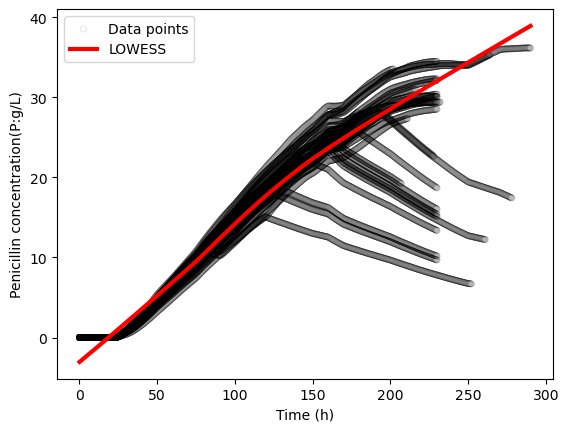

In [22]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Penicillin concentration(P:g/L)')

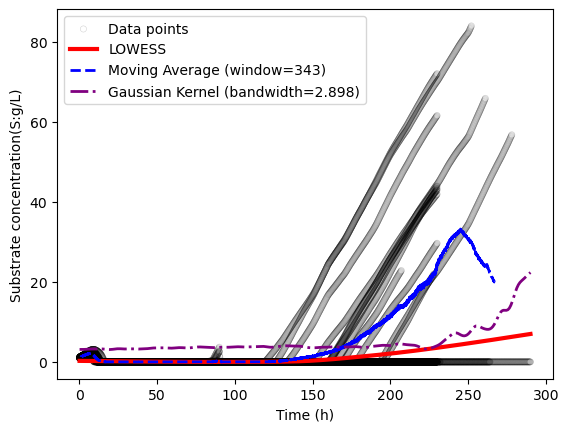

In [23]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Substrate concentration(S:g/L)', moving_average=not None, gaussian_kernel=not None)

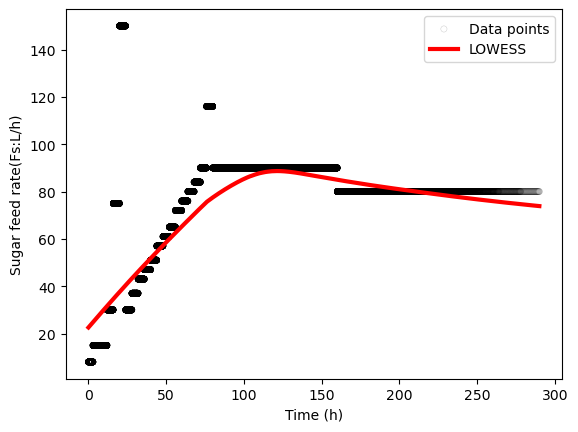

In [24]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Sugar feed rate(Fs:L/h)')

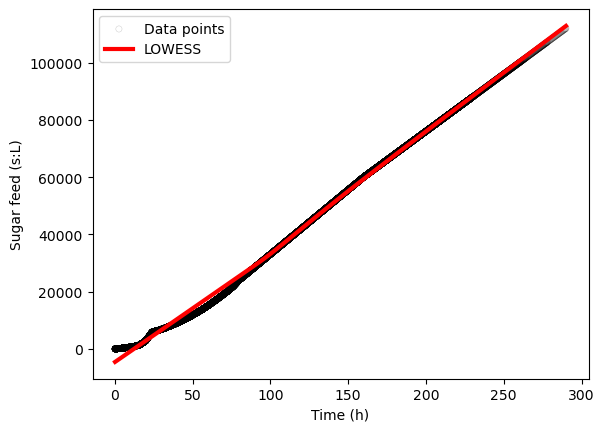

In [25]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Sugar feed (s:L)')

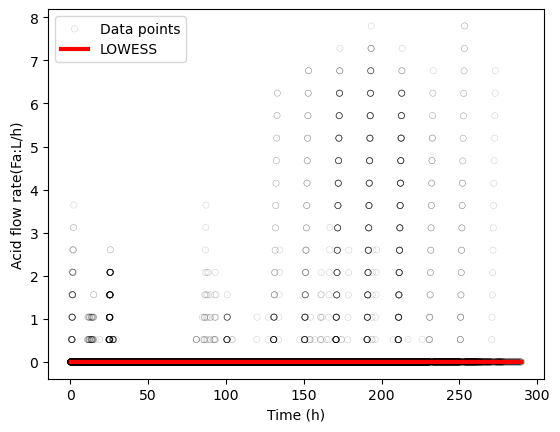

In [26]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Acid flow rate(Fa:L/h)')

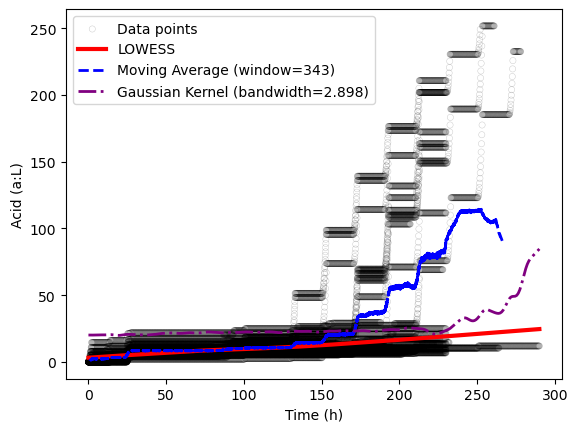

In [27]:
smoothing(data=variable_data_recipe, time='Time (h)', variable='Acid (a:L)', moving_average=not None, gaussian_kernel=not None)

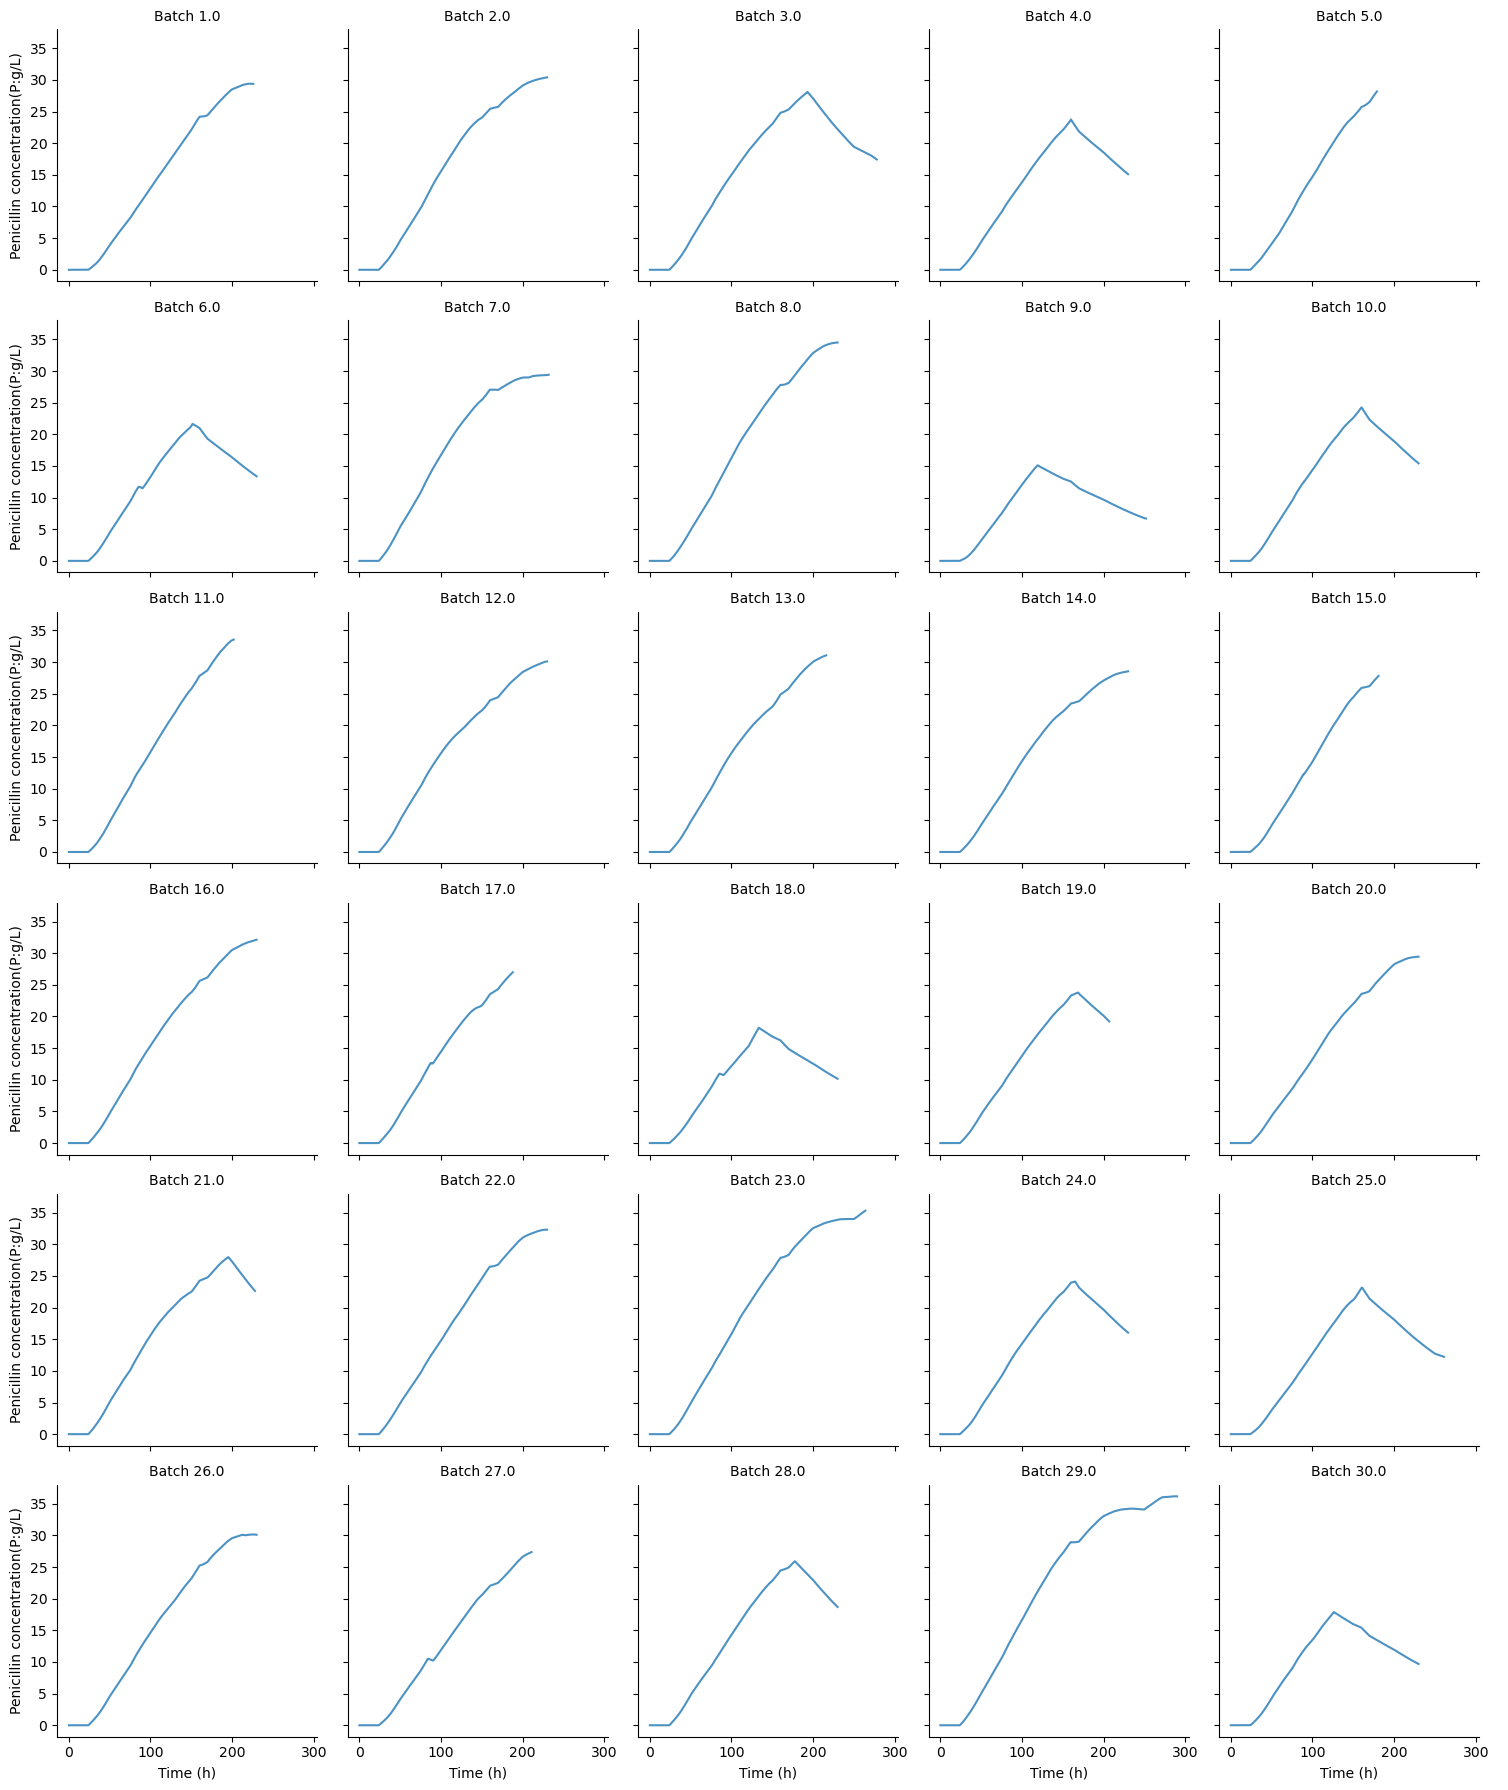

In [28]:
g = sns.FacetGrid(data=variable_data_recipe, col='Batch reference(Batch_ref:Batch ref)', col_wrap=5, sharey=True)
g.map(sns.lineplot, 'Time (h)', 'Penicillin concentration(P:g/L)', alpha=0.8)
g.set_titles("Batch {col_name}")
g.add_legend()

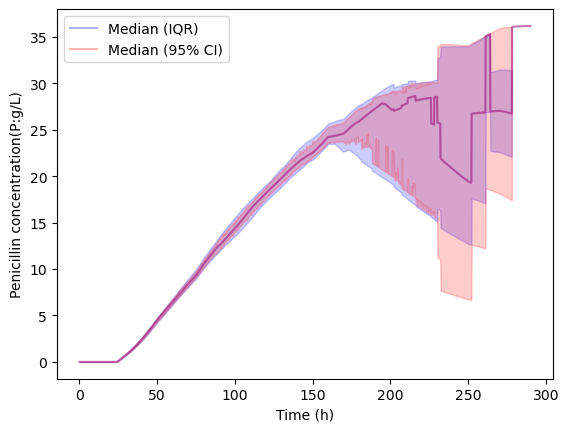

In [29]:
sns.lineplot(data=variable_data_recipe, x='Time (h)', y='Penicillin concentration(P:g/L)', estimator='median', errorbar=('pi', 50), err_style='band', color='blue', alpha=0.3, label='Median (IQR)')
sns.lineplot(data=variable_data_recipe, x='Time (h)', y='Penicillin concentration(P:g/L)', estimator='median', errorbar=('ci', 95), err_style='band', color='red', alpha=0.3, label='Median (95% CI)')
plt.legend()
plt.show()

<Axes: xlabel='Time (h)', ylabel='Batch reference(Batch_ref:Batch ref)'>

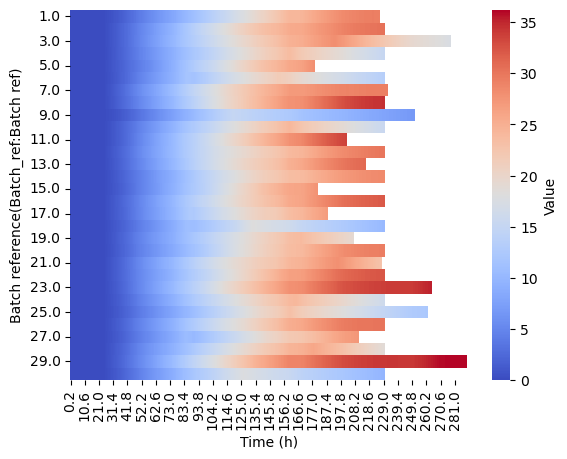

In [30]:
pivot_df = variable_data_recipe.pivot_table(index='Batch reference(Batch_ref:Batch ref)', columns='Time (h)', values='Penicillin concentration(P:g/L)', aggfunc='median')
sns.heatmap(pivot_df, cmap='coolwarm', cbar_kws={'label': 'Value'})

C:\Users\lenovo\AppData\Local\Temp\ipykernel_9508\1949354903.py:6: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = variable_data_recipe.pivot_table(index='Batch reference(Batch_ref:Batch ref)', columns='Time_binned', values='Penicillin concentration(P:g/L)', aggfunc='median')


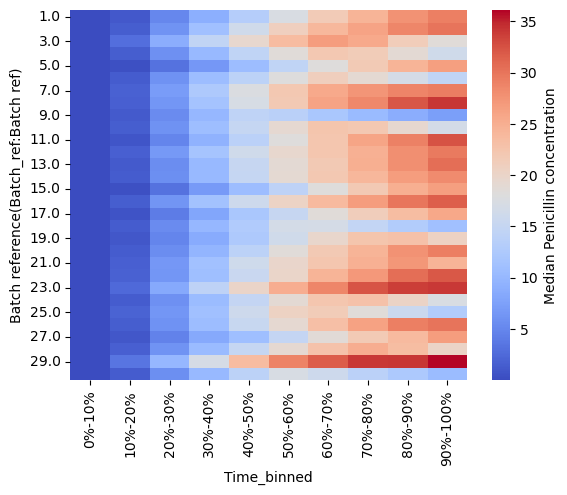

In [31]:
variable_data_recipe['Time_normalized'] = variable_data_recipe.groupby('Batch reference(Batch_ref:Batch ref)')['Time (h)'].transform(lambda x: (x - x.min()) / (x.max() - x.min()) * 100)

bins = np.linspace(0, 100, 11)
variable_data_recipe['Time_binned'] = pd.cut(variable_data_recipe['Time_normalized'], bins=bins, labels=[f"{i}%-{i+10}%" for i in range(0, 100, 10)])

pivot_df = variable_data_recipe.pivot_table(index='Batch reference(Batch_ref:Batch ref)', columns='Time_binned', values='Penicillin concentration(P:g/L)', aggfunc='median')

sns.heatmap(pivot_df, cmap='coolwarm', cbar_kws={'label': 'Median Penicillin concentration'})
plt.show()

In [32]:
def plot_time_binned_boxplot(data, time, variable, groupvar=None, figsize=(12, 6)):

    # Calculate quartiles and interquartile range (IQR) for Time (h)
    q25, q75 = np.percentile(data[time], [25, 75])
    iqr = q75 - q25
    # Calculate optimal bin width using Freedman-Diaconis rule
    bin_width = 2 * iqr / (len(data[time]) ** (1/3))
    # Calculate number of bins based on data range and bin width
    n_bins_fd = int((data[time].max() - data[time].min()) / bin_width)

    # Create time bins
    n_bins = n_bins_fd
    data = data.copy()
    data['time_bin'] = pd.cut(data[time], bins=n_bins)
    bin_midpoints = [interval.mid for interval in data['time_bin'].cat.categories]

    plt.figure(figsize=figsize)

    if groupvar:
        box = sns.boxplot(data=data, x='time_bin', y=variable, hue=groupvar, showfliers=False, linewidth=1, dodge=True, width=0.8)
        for i, (status, group) in enumerate(data.groupby(groupvar, observed=False)):
            bin_medians = group.groupby('time_bin', observed=False)[variable].median()
            x_positions = np.arange(len(bin_medians)) + (-0.2 if i==0 else 0.2)
            plt.plot(x_positions, bin_medians, marker='o', markersize=4, linestyle='--', label=f'{status} median')
    
    else:
        box = sns.boxplot(data=data, x='time_bin', y=variable)
        bin_medians = data.groupby('time_bin', observed=False)[variable].median()
        plt.plot(range(len(bin_medians)), bin_medians, color='red', marker='o', markersize=4, linestyle='--', label='Median trend')

    # Format x-axis
    box.set_xticks(range(len(bin_midpoints)))
    box.set_xticklabels([f"{x:.2f}" for x in bin_midpoints], rotation=90, ha='right')

    # Add labels and legend
    plt.xlabel('Time Bins Midpoint (h)')
    plt.ylabel(variable)
    plt.legend()
    plt.tight_layout()
    plt.show()

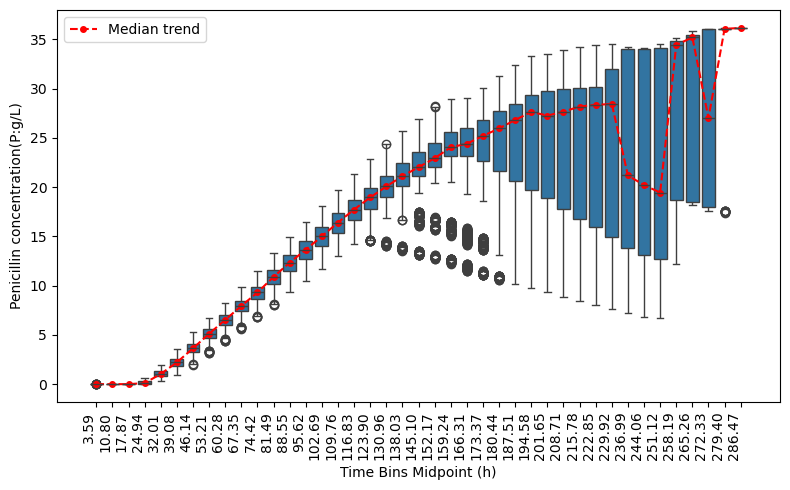

In [33]:
plot_time_binned_boxplot(data=variable_data_recipe, time='Time (h)', variable='Penicillin concentration(P:g/L)', groupvar=None, figsize=(8, 5))

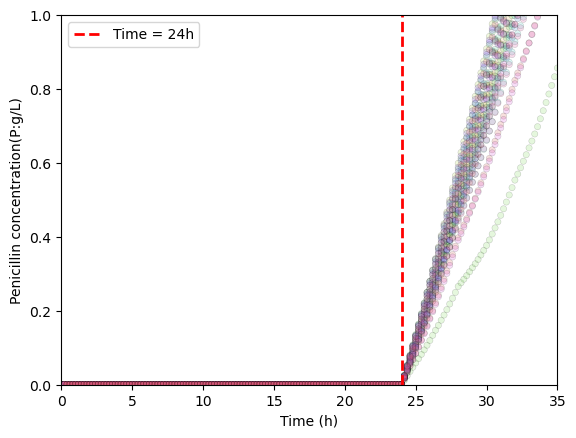

In [34]:
sns.scatterplot(data=variable_data_recipe, x='Time (h)', y='Penicillin concentration(P:g/L)', hue='Batch reference(Batch_ref:Batch ref)', palette='hls' , facecolor='none', edgecolor='black', s=20, alpha=0.2, legend=False)
plt.axvline(x=24, color='red', linestyle='--', linewidth=2, label='Time = 24h')
plt.xlim(0, 35)
plt.ylim(0, 1)
plt.legend(loc='upper left')
plt.show()

In [35]:
# Categozie data into two metabolic phases: Phase 1 (Growth phase), Phase 2 (Production phase)
variable_data_recipe_phase1 = variable_data_recipe[variable_data_recipe['Time (h)'] <= 24.0]
variable_data_recipe_phase2 = variable_data_recipe[variable_data_recipe['Time (h)'] > 24.0]

In [36]:
# Initialize a dictionary to store results
results = {'Batch': [], 'Initial rate (g/L/h)': [], 'Initial rate CI lower': [], 'Initial rate CI upper': [], 'Initial rate p-value': [], 
           'Final rate (g/L/h)': [], 'Final rate CI lower': [], 'Final rate CI upper': [], 'Final rate p-value': [],
           'Breakpoint (h)': [], 'Breakpoint CI lower': [], 'Breakpoint CI upper': [],
           'Adjusted R Squared': [], 'Davies test p-value': []
           }

# Get unique batch identifiers
batch_ref = variable_data_recipe_phase2['Batch reference(Batch_ref:Batch ref)'].unique()

# Process each batch
for batch in batch_ref:
    print(f"Processing Batch {batch} ...")

    # Extract data for this batch
    batch_data = variable_data_recipe_phase2[variable_data_recipe_phase2['Batch reference(Batch_ref:Batch ref)'] == batch]
    # Get time and penicillin values
    time = batch_data['Time (h)'].values
    penicillin = batch_data['Penicillin concentration(P:g/L)'].values
    # Apply piecewise regression with one breakpoint
    pw_fit = piecewise_regression.Fit(time, penicillin, n_breakpoints=1)
    pw_summary = pw_fit.summary()
    pw_results = pw_fit.get_results()
    pw_estimates = pw_results["estimates"]
    pw_davies = pw_results["davies"]
    # Extract Adjusted R squared from summary
    adj_r2 = None
    for line in pw_summary.split('\n'):
        if "Adjusted R Squared" in line:
            adj_r2 = float(line.split()[-1])
            break
    
    # Store results in the dictionary
    results['Batch'].append(batch)
    results['Initial rate (g/L/h)'].append(pw_estimates['alpha1']['estimate'])
    results['Initial rate CI lower'].append(pw_estimates['alpha1']['confidence_interval'][0])
    results['Initial rate CI upper'].append(pw_estimates['alpha1']['confidence_interval'][1])
    results['Initial rate p-value'].append(pw_estimates['alpha1']['p_t'])
    results['Final rate (g/L/h)'].append(pw_estimates['alpha2']['estimate'])
    results['Final rate CI lower'].append(pw_estimates['alpha2']['confidence_interval'][0])
    results['Final rate CI upper'].append(pw_estimates['alpha2']['confidence_interval'][1])
    results['Final rate p-value'].append(pw_estimates['alpha2']['p_t'])
    results['Breakpoint (h)'].append(pw_estimates['breakpoint1']['estimate'])
    results['Breakpoint CI lower'].append(pw_estimates['breakpoint1']['confidence_interval'][0])
    results['Breakpoint CI upper'].append(pw_estimates['breakpoint1']['confidence_interval'][1])
    results['Adjusted R Squared'].append(adj_r2)
    results['Davies test p-value'].append(pw_davies)
    
    # Plot the data, fit, breakpoints and confidence intervals
    pw_fit.plot_data(color='grey', s=20)
    pw_fit.plot_fit(color='red', linewidth=4)
    pw_fit.plot_breakpoints()
    pw_fit.plot_breakpoint_confidence_intervals()
    plt.title(f"Batch {batch}")
    plt.xlabel("Time (h)")
    plt.ylabel("Penicillin concentration (P:g/L)")
    plt.tight_layout()
    plt.close()

# Convert results to DataFrame
piecewise_df = pd.DataFrame(results)

Processing Batch 1.0 ...

                    Breakpoint Regression Results                     
No. Observations                     1010
No. Model Parameters                    4
Degrees of Freedom                   1006
Res. Sum of Squares               76.5051
Total Sum of Squares              90716.8
R Squared                        0.999157
Adjusted R Squared               0.999153
Converged:                           True
                    Estimate      Std Err            t        P>|t|       [0.025       0.975]
----------------------------------------------------------------------------------------------------
const               -5.23625       0.0267       -195.8           0.0      -5.2887      -5.1838
alpha1              0.181901     0.000265       687.24           0.0      0.18138      0.18242
beta1             -0.0849655     0.000868      -97.887             -    -0.086669    -0.083262
breakpoint1          161.786        0.438            -             -       160.93      

In [37]:
piecewise_df

,Batch,Initial rate (g/L/h),Initial rate CI lower,Initial rate CI upper,Initial rate p-value,Final rate (g/L/h),Final rate CI lower,Final rate CI upper,Final rate p-value,Breakpoint (h),Breakpoint CI lower,Breakpoint CI upper,Adjusted R Squared,Davies test p-value
0,1.0,0.181901,0.181382,0.182420,0.0,0.096936,0.095313,0.098558,0.000000e+00,161.785506,160.926325,162.644687,0.999153,0.0
1,2.0,0.211502,0.210803,0.212202,0.0,0.088438,0.087511,0.089364,0.000000e+00,136.747932,136.199014,137.296849,0.999180,0.0
2,3.0,0.179326,0.178241,0.180412,0.0,-0.123056,-0.125269,-0.120843,0.000000e+00,180.678270,180.154065,181.202475,0.991954,0.0
3,4.0,0.181319,0.180865,0.181773,0.0,-0.116059,-0.117120,-0.114998,0.000000e+00,155.541440,155.349076,155.733804,0.998896,0.0
4,5.0,0.206643,0.205996,0.207291,0.0,0.128863,0.125575,0.132151,0.000000e+00,139.842589,138.734073,140.951105,0.999072,0.0
5,6.0,0.176286,0.175649,0.176923,0.0,-0.105026,-0.106210,-0.103842,0.000000e+00,148.036328,147.779345,148.293310,0.997737,0.0
6,7.0,0.217101,0.216232,0.217971,0.0,0.049434,0.048057,0.050810,0.000000e+00,143.896174,143.345305,144.447042,0.998430,0.0
7,8.0,0.221055,0.220241,0.221869,0.0,0.117915,0.116636,0.119194,0.000000e+00,142.467003,141.639333,143.294673,0.998992,0.0
8,9.0,0.169488,0.168915,0.170061,0.0,-0.064792,-0.065132,-0.064451,0.000000e+00,118.482308,118.308288,118.656329,0.998108,0.0
9,10.0,0.187454,0.186859,0.188048,0.0,-0.118543,-0.119897,-0.117188,0.000000e+00,154.628797,154.386574,154.871021,0.998231,0.0


C:\Users\lenovo\AppData\Local\Temp\ipykernel_9508\3871777674.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([label.get_text().split('.')[0] for label in ax.get_xticklabels()])


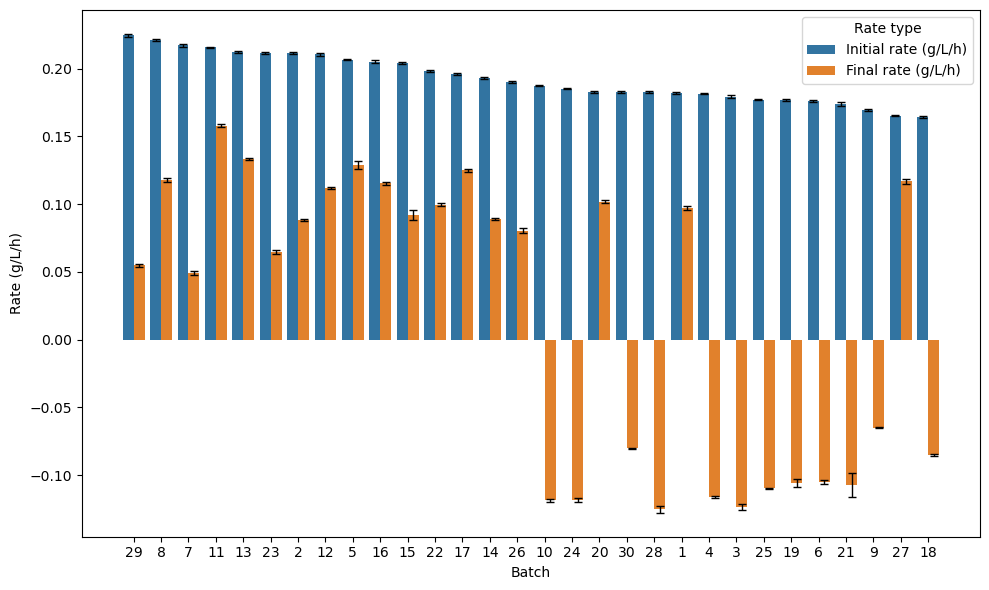

In [38]:
plt.figure(figsize=(10, 6))
sorted_batches = piecewise_df.sort_values('Initial rate (g/L/h)', ascending=False)['Batch']

ax = sns.barplot(data=piecewise_df.melt(id_vars=['Batch'], value_vars=['Initial rate (g/L/h)', 'Final rate (g/L/h)'], var_name='Rate type'), x='Batch', y='value', hue='Rate type', order=sorted_batches, capsize=0, dodge=True)

for i, (_, batch_data) in enumerate(piecewise_df.set_index('Batch').loc[sorted_batches].iterrows()):
    ax.errorbar(x=i-0.2, y=batch_data['Initial rate (g/L/h)'], yerr=[[batch_data['Initial rate (g/L/h)'] - batch_data['Initial rate CI lower']], [batch_data['Initial rate CI upper'] - batch_data['Initial rate (g/L/h)']]], 
                fmt='none', ecolor='black', capsize=3, elinewidth=1)
    ax.errorbar(x=i+0.2, y=batch_data['Final rate (g/L/h)'], yerr=[[batch_data['Final rate (g/L/h)'] - batch_data['Final rate CI lower']], [batch_data['Final rate CI upper'] - batch_data['Final rate (g/L/h)']]], 
                fmt='none', ecolor='black', capsize=3, elinewidth=1)

ax.set_xticklabels([label.get_text().split('.')[0] for label in ax.get_xticklabels()])
plt.ylabel("Rate (g/L/h)")
plt.legend(title='Rate type')
plt.tight_layout()
plt.show()

In [39]:
# Create binary batch status column (0=Success, 1=Failed) based on final growth rate
# Mark as Success (0) if final rate >= 0
# Mark as Failed (1) if final rate < 0
variable_data_recipe['Batch status'] = np.where(variable_data_recipe['Batch reference(Batch_ref:Batch ref)'].isin(piecewise_df[piecewise_df['Final rate (g/L/h)'] >= 0]['Batch'].unique()), 0, 1)
# Convert to categorical type
variable_data_recipe['Batch status'] = variable_data_recipe['Batch status'].astype('category')
variable_data_recipe['Batch status'] = variable_data_recipe['Batch status'].cat.rename_categories({0: 'Success', 1: 'Failed'})

# Merge key rate parameters from piecewise_df using map
for col in ['Initial rate (g/L/h)', 'Final rate (g/L/h)', 'Breakpoint (h)']:
    variable_data_recipe[col] = variable_data_recipe['Batch reference(Batch_ref:Batch ref)'].map(piecewise_df.set_index('Batch')[col])

# Split data into two time phases
variable_data_recipe_phase1 = variable_data_recipe[variable_data_recipe['Time (h)'] <= 24.0]
variable_data_recipe_phase2 = variable_data_recipe[variable_data_recipe['Time (h)'] > 24.0]

# Filter main dataset
success_batch_data = variable_data_recipe[variable_data_recipe['Batch status'] == 'Success']
failed_batch_data = variable_data_recipe[variable_data_recipe['Batch status'] == 'Failed']

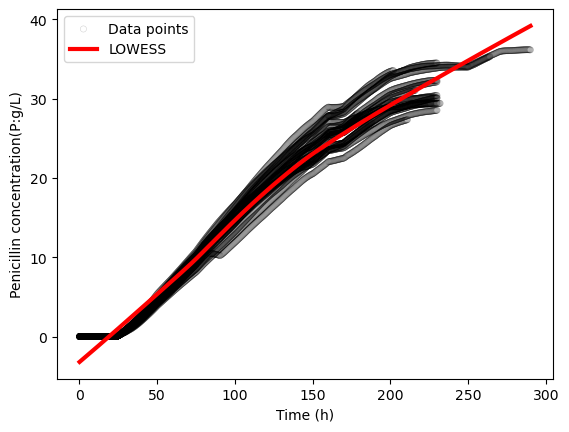

In [40]:
smoothing(data=success_batch_data, time='Time (h)', variable='Penicillin concentration(P:g/L)')

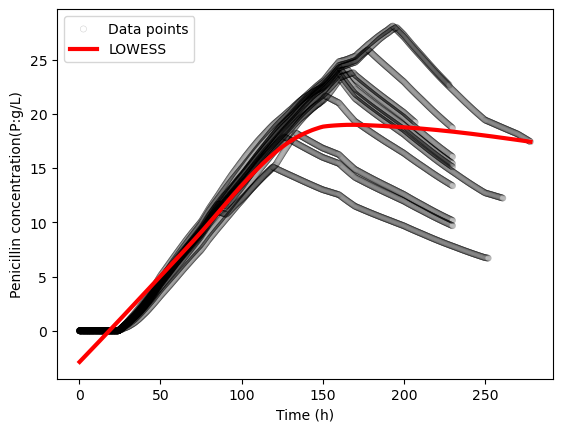

In [41]:
smoothing(data=failed_batch_data, time='Time (h)', variable='Penicillin concentration(P:g/L)')

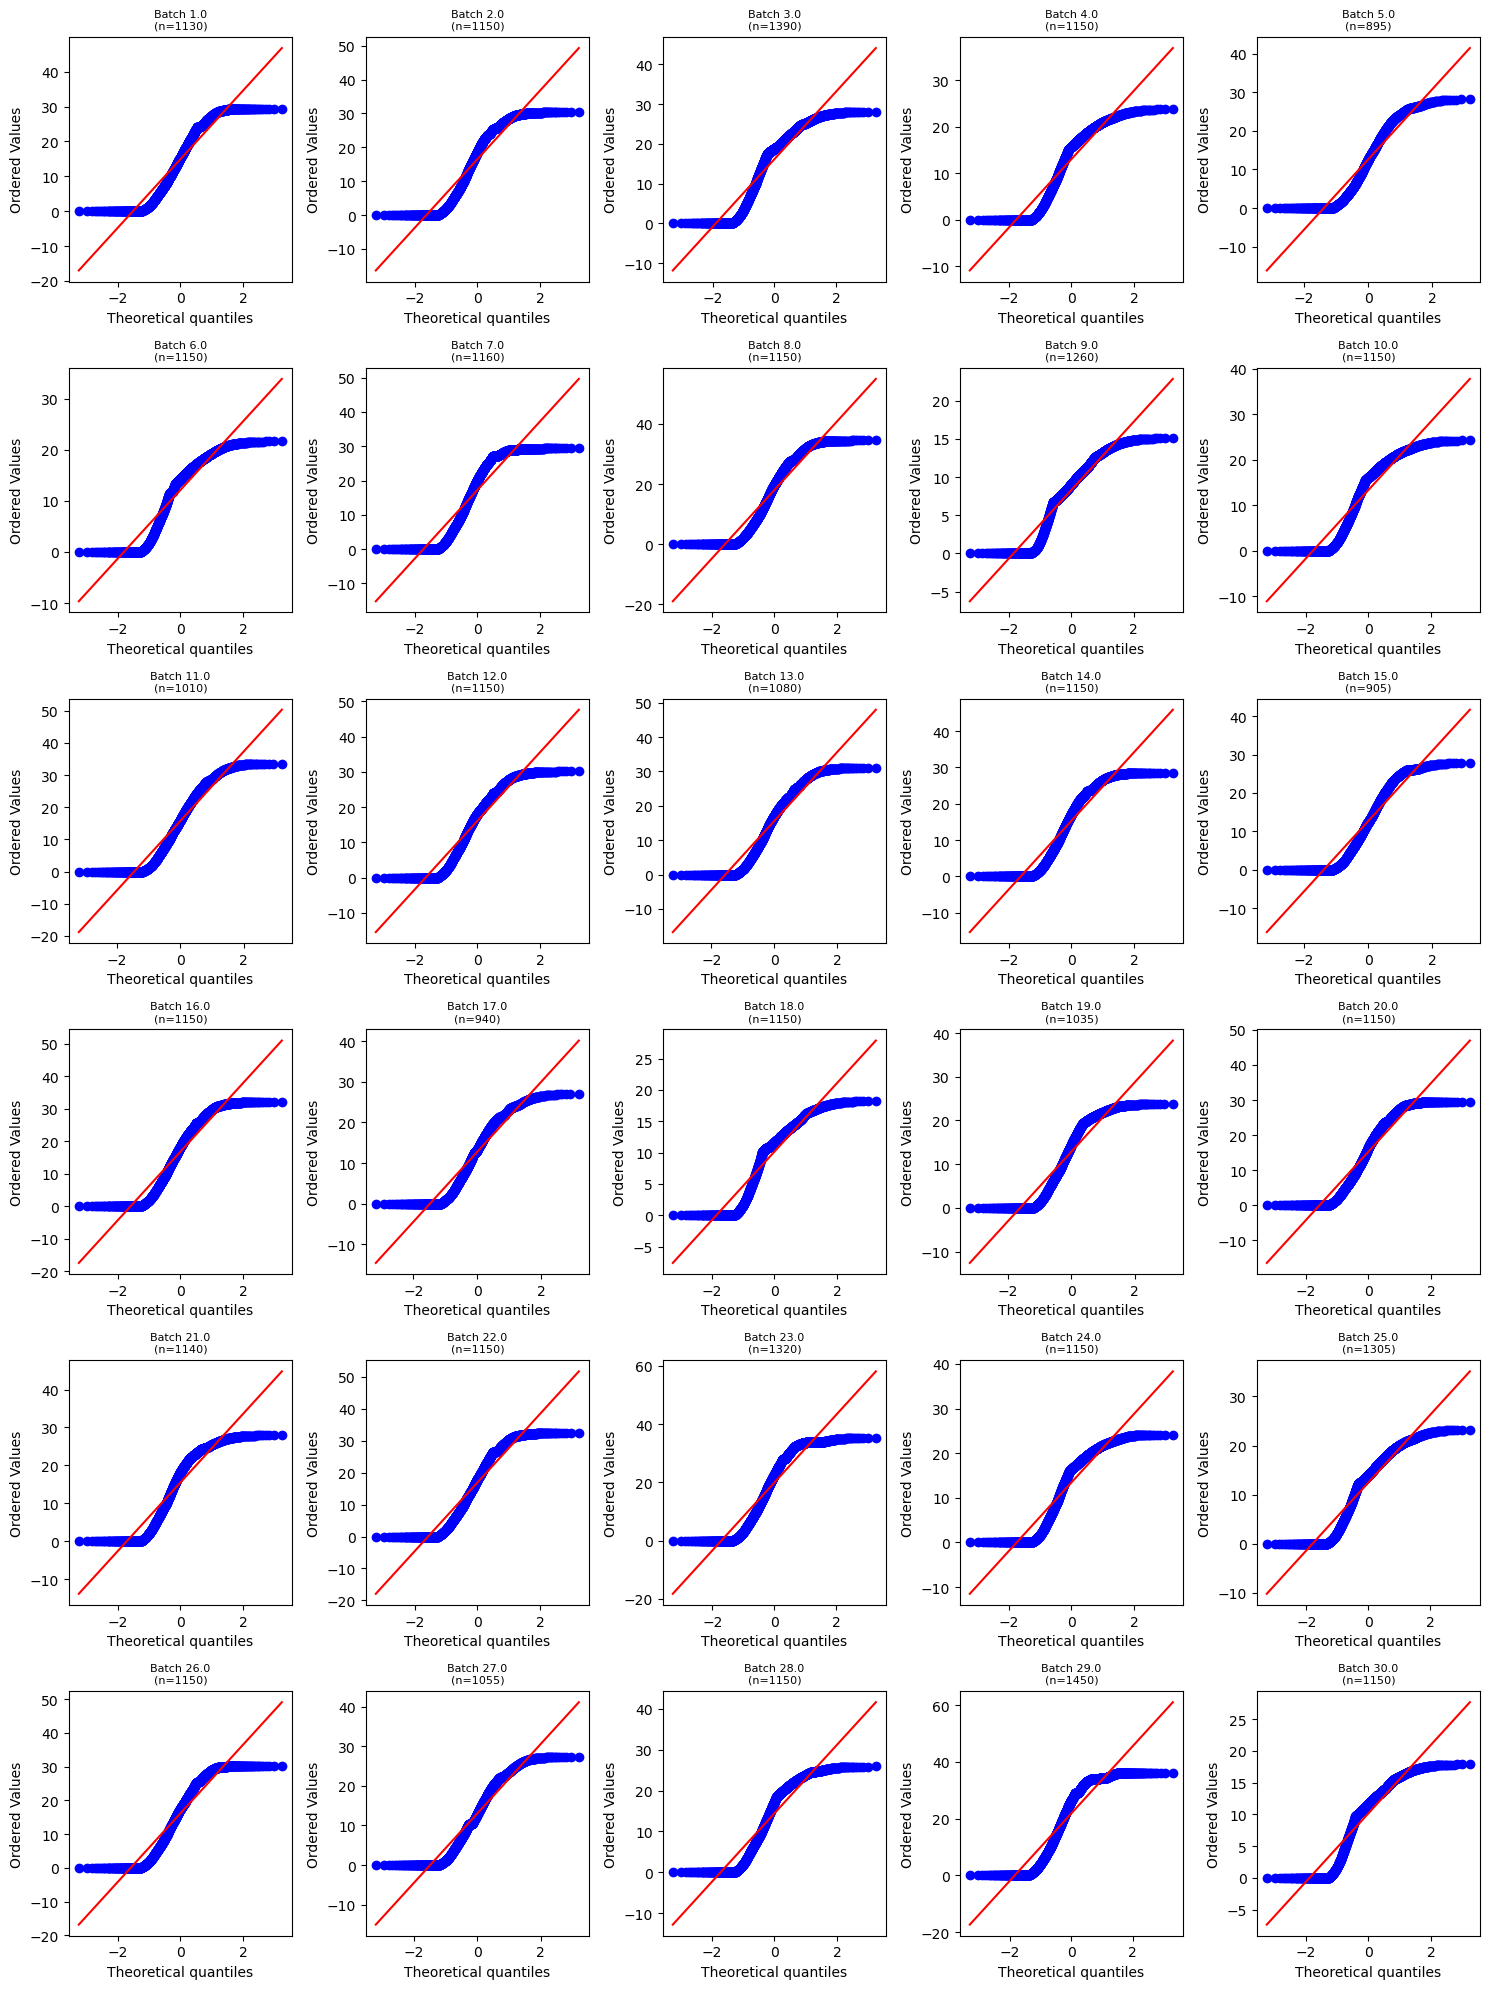

In [42]:
from scipy import stats

plt.figure(figsize=(15, 20))

for i, batch in enumerate(variable_data_recipe['Batch reference(Batch_ref:Batch ref)'].unique(), 1):
    batch_data = variable_data_recipe[variable_data_recipe['Batch reference(Batch_ref:Batch ref)'] == batch]
    conc = batch_data['Penicillin concentration(P:g/L)'].dropna()
    plt.subplot(6, 5, i)
    stats.probplot(conc, dist="norm", plot=plt)
    plt.title(f'Batch {batch}\n(n={len(conc)})', fontsize=8)

plt.tight_layout()
plt.show()

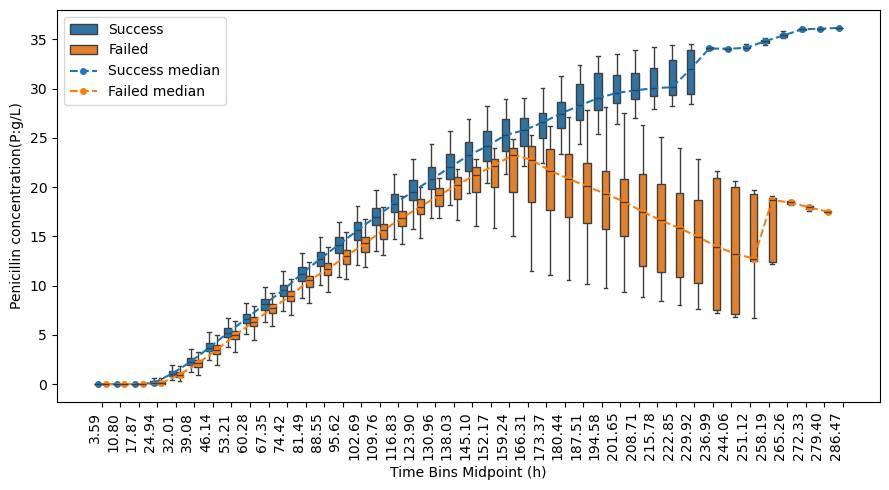

In [43]:
plot_time_binned_boxplot(data=variable_data_recipe, time='Time (h)', variable='Penicillin concentration(P:g/L)', groupvar='Batch status', figsize=(9, 5))

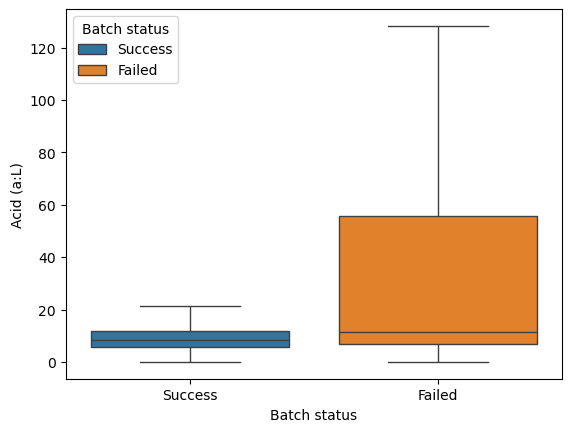

In [44]:
ax = sns.boxplot(data=variable_data_recipe, x='Batch status', y='Acid (a:L)', hue='Batch status', legend=True, showfliers=False)
plt.show()

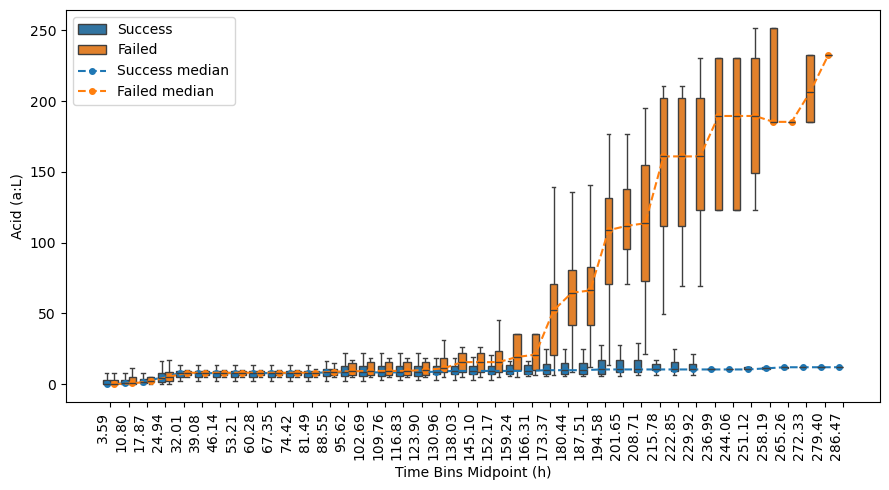

In [45]:
plot_time_binned_boxplot(data=variable_data_recipe, time='Time (h)', variable='Acid (a:L)', groupvar='Batch status', figsize=(9, 5))

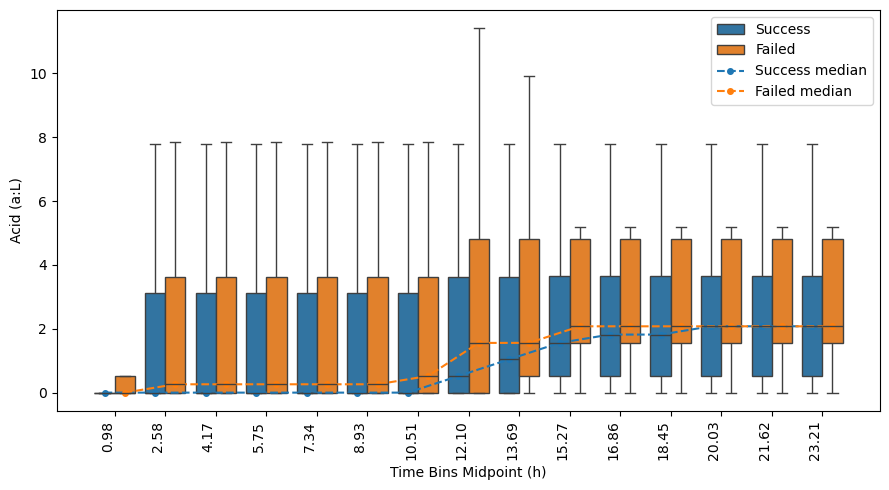

In [46]:
plot_time_binned_boxplot(data=variable_data_recipe_phase1, time='Time (h)', variable='Acid (a:L)', groupvar='Batch status', figsize=(9, 5))

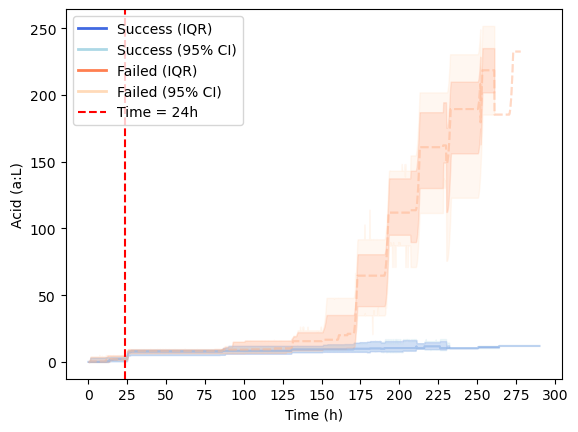

In [47]:
pi_plot = sns.lineplot(data=variable_data_recipe, x='Time (h)', y='Acid (a:L)', hue='Batch status', style='Batch status', estimator='median', errorbar=('pi', 50), palette={'Success': 'royalblue', 'Failed': 'coral'}, alpha=0.3)
ci_plot = sns.lineplot(data=variable_data_recipe, x='Time (h)', y='Acid (a:L)', hue='Batch status', style='Batch status', estimator='median', errorbar=('ci', 95), palette={'Success': 'lightblue', 'Failed': 'peachpuff'}, alpha=0.3)
plt.gca().legend_.remove()
plt.xticks(range(0, 301, 25))
plt.axvline(x=24, linestyle='--', color='red', label='Time = 24h')
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='royalblue', lw=2, label='Success (IQR)'), 
                   Line2D([0], [0], color='lightblue', lw=2, label='Success (95% CI)'), 
                   Line2D([0], [0], color='coral', lw=2, label='Failed (IQR)'), 
                   Line2D([0], [0], color='peachpuff', lw=2, label='Failed (95% CI)'),
                   Line2D([0], [0], color='red', linestyle='--', label='Time = 24h')]
plt.legend(handles=legend_elements, loc='upper left')
plt.show()